In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torchvision import transforms

from vit_pytorch.efficient import ViT
from datasets import load_dataset

In [4]:
# !rm -rf home1/08823/msrodlab/.cache/huggingface/datasets/json
dataset = load_dataset("json", data_files={'train': 'train-metadata.jsonl', 'test': 'test-metadata.jsonl'})

Found cached dataset json (C:/Users/Michael Labarca/.cache/huggingface/datasets/json/default-cdfdfcbc8e66950a/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['uniqueId', 'image', 'ttf_path', 'font_characteristics', 'character', 'font_properties'],
    num_rows: 12028
})
Dataset({
    features: ['uniqueId', 'image', 'ttf_path', 'font_characteristics', 'character', 'font_properties'],
    num_rows: 814
})


['lower_i']
['upper_E']
['lower_w']
['lower_w']
['upper_R']
['3']
['upper_Q']
['lower_y']
['lower_d']


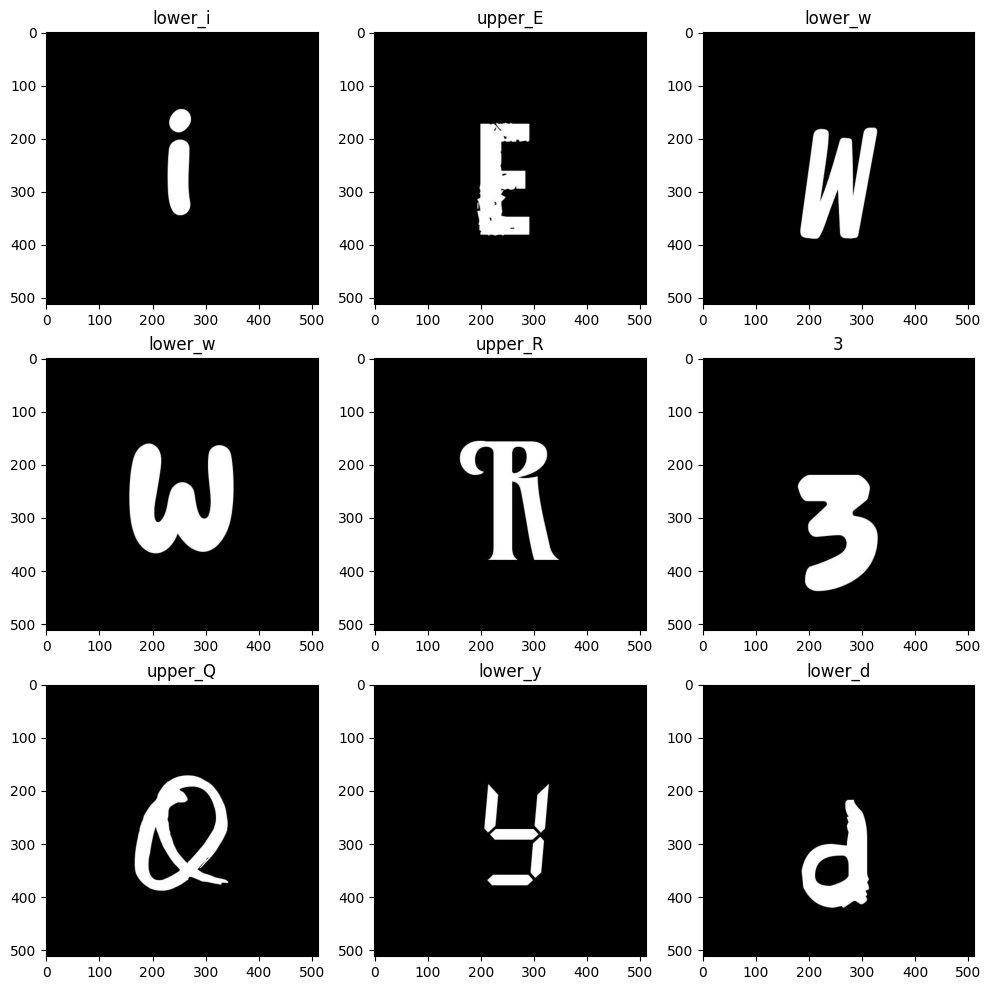

In [7]:

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx, ax in enumerate(axes.ravel()):
    r_idx = np.random.randint(len(train_dataset), size=(1,))
    ex = train_dataset[r_idx]
    img = Image.open(ex['image'][0])
    print(ex['character'])
    ax.set_title(ex['character'][0])
    ax.imshow(img)

In [17]:
img = Image.open(train_dataset[0]['image'])
print(img)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x2DD05BF2880>


In [13]:
from datasets import Image as DImage
from datasets.features import Array3D
import torch
def map_label(example):
    example["character"] = label_map[example['character']]
    return example

def map_img(example):
    # Define a transform to convert the image to tensor
    transform = transforms.ToTensor()
    # Convert the image to PyTorch tensor
    tensor = transform(example['image'])
    example['image'] = tensor
    return example
train_dataset = dataset['train']
test_dataset = dataset['test']
print(train_dataset)
print(test_dataset)
train_dataset_cols_removed = train_dataset.remove_columns(['uniqueId', 'ttf_path', 'font_characteristics', 'font_properties'])
casted_train_dataset = train_dataset_cols_removed.cast_column('image', DImage())
casted_train_dataset = train_dataset_cols_removed.cast_column('image', Array3D((512, 512, 3), dtype='int8'))

test_dataset_cols_removed = test_dataset.remove_columns(['uniqueId', 'ttf_path', 'font_characteristics', 'font_properties'])
casted_test_dataset = test_dataset_cols_removed.cast_column('image', DImage())
casted_test_dataset = casted_test_dataset.cast_column('image', transforms.PILToTensor())

# casted_train_dataset = casted_train_dataset.map(map_img)
# casted_test_dataset = casted_test_dataset.map(map_img)

chars = train_dataset_cols_removed['character'][0:62]
label_map = {chars[idx]: idx for idx in range(len(chars))}
labeled_casted_train_dataset = casted_train_dataset.map(map_label)
labeled_casted_test_dataset = casted_test_dataset.map(map_label)



chars = train_dataset_cols_removed['character'][0:62]
train_loader = DataLoader(dataset = labeled_casted_train_dataset, batch_size=8, shuffle=True )
valid_loader = DataLoader(dataset = labeled_casted_test_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Dataset({
    features: ['uniqueId', 'image', 'ttf_path', 'font_characteristics', 'character', 'font_properties'],
    num_rows: 12028
})
Dataset({
    features: ['uniqueId', 'image', 'ttf_path', 'font_characteristics', 'character', 'font_properties'],
    num_rows: 814
})


Casting the dataset:   0%|          | 0/12028 [00:00<?, ? examples/s]

TypeError: Incompatible storage type for extension<arrow.py_extension_type<Array3DExtensionType>>: expected list<item: list<item: list<item: int8>>>, got string

In [10]:
print(labeled_casted_train_dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x22EBCFF1A00>, 'character': 0}


In [9]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=64+1,  # 8x8 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)
device = 'cuda'
model = ViT(
    dim=128,
    image_size=256,
    patch_size=32,
    num_classes=62,
    transformer=efficient_transformer,
    channels=3,
).to(device)
# loss function
lr = 3e-5
gamma = 0.7
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(4):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        print(data, label)
        # data = data.to(device)
        # label = label.to(device)

        # output = model(data)
        # loss = criterion(output, label)

        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        # acc = (output.argmax(dim=1) == label).float().mean()
        # epoch_accuracy += acc / len(train_loader)
        # epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/1504 [00:00<?, ?it/s]

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>